In [ ]:
#Dependencies
import pandas as pd
import pickle
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, fbeta_score,precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
import xgboost as xgb


In [ ]:
# Loaded dataset
drive.mount('/content/drive')
file = '/content/drive/MyDrive/Churn_Modelling.csv'
df = pd.read_csv(file, encoding='latin1')
df.head()

Mounted at /content/drive


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.shape

(10000, 14)

In [ ]:
'''columns_to_drop =
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')
df'''

"columns_to_drop = \ndf.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')\ndf"

In [ ]:
df_gen = pd.get_dummies(df, columns=['Gender'])

df_gen

,RowNumber,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,France,42,2,0.00,1,1,1,101348.88,1,True,False
1,2,15647311,Hill,608,Spain,41,1,83807.86,1,0,1,112542.58,0,True,False
2,3,15619304,Onio,502,France,42,8,159660.80,3,1,0,113931.57,1,True,False
3,4,15701354,Boni,699,France,39,1,0.00,2,0,0,93826.63,0,True,False
4,5,15737888,Mitchell,850,Spain,43,2,125510.82,1,1,1,79084.10,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,39,5,0.00,2,1,0,96270.64,0,False,True
9996,9997,15569892,Johnstone,516,France,35,10,57369.61,1,1,1,101699.77,0,False,True
9997,9998,15584532,Liu,709,France,36,7,0.00,1,0,1,42085.58,1,True,False
9998,9999,15682355,Sabbatini,772,Germany,42,3,75075.31,2,1,0,92888.52,1,False,True


In [ ]:
#One Hot Encoding for Ages
bins = [0, 20, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80+']
df['AgeGroup'] = pd.cut(df_gen['Age'], bins=bins, labels=labels, right=False)

df_encoded = pd.get_dummies(df_gen, columns=['Age'], prefix='Age')

#Converting the bool values to encodings
df_new = df_encoded.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)
df_new

<ipython-input-6-4186162086>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new = df_encoded.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Age_78,Age_79,Age_80,Age_81,Age_82,Age_83,Age_84,Age_85,Age_88,Age_92
0,1,15634602,Hargrave,619,France,2,0.00,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,Hill,608,Spain,1,83807.86,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,15619304,Onio,502,France,8,159660.80,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,Boni,699,France,1,0.00,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,15737888,Mitchell,850,Spain,2,125510.82,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,5,0.00,2,1,0,...,0,0,0,0,0,0,0,0,0,0
9996,9997,15569892,Johnstone,516,France,10,57369.61,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9997,9998,15584532,Liu,709,France,7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9998,9999,15682355,Sabbatini,772,Germany,3,75075.31,2,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Credit Score
df_new['CreditGroup'] = pd.cut(df_new['CreditScore'], bins=[300, 550, 700, 850], labels=['Low', 'Medium', 'High'])
df_credit = pd.get_dummies(df_new, columns=['CreditGroup'], prefix='CreditGroup', drop_first=True)
df_credit


,RowNumber,CustomerId,Surname,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Age_80,Age_81,Age_82,Age_83,Age_84,Age_85,Age_88,Age_92,CreditGroup_Medium,CreditGroup_High
0,1,15634602,Hargrave,619,France,2,0.00,1,1,1,...,0,0,0,0,0,0,0,0,True,False
1,2,15647311,Hill,608,Spain,1,83807.86,1,0,1,...,0,0,0,0,0,0,0,0,True,False
2,3,15619304,Onio,502,France,8,159660.80,3,1,0,...,0,0,0,0,0,0,0,0,False,False
3,4,15701354,Boni,699,France,1,0.00,2,0,0,...,0,0,0,0,0,0,0,0,True,False
4,5,15737888,Mitchell,850,Spain,2,125510.82,1,1,1,...,0,0,0,0,0,0,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,5,0.00,2,1,0,...,0,0,0,0,0,0,0,0,False,True
9996,9997,15569892,Johnstone,516,France,10,57369.61,1,1,1,...,0,0,0,0,0,0,0,0,False,False
9997,9998,15584532,Liu,709,France,7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,False,True
9998,9999,15682355,Sabbatini,772,Germany,3,75075.31,2,1,0,...,0,0,0,0,0,0,0,0,False,True


In [ ]:
main = df_credit.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)
main

<ipython-input-8-3629484836>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  main = df_credit.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Age_80,Age_81,Age_82,Age_83,Age_84,Age_85,Age_88,Age_92,CreditGroup_Medium,CreditGroup_High
0,1,15634602,Hargrave,619,France,2,0.00,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,2,15647311,Hill,608,Spain,1,83807.86,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,Onio,502,France,8,159660.80,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,Boni,699,France,1,0.00,2,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,15737888,Mitchell,850,Spain,2,125510.82,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,5,0.00,2,1,0,...,0,0,0,0,0,0,0,0,0,1
9996,9997,15569892,Johnstone,516,France,10,57369.61,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9997,9998,15584532,Liu,709,France,7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,0,1
9998,9999,15682355,Sabbatini,772,Germany,3,75075.31,2,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Tenure
main['TenureGroup'] = pd.cut(main['Tenure'], bins=[0, 2, 5, 10], labels=['New', 'Mid-term', 'Loyal'])
df_tenure = pd.get_dummies(main, columns=['TenureGroup'], drop_first=True)
main2 = df_tenure.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)
main2

<ipython-input-9-3709889454>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  main2 = df_tenure.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Age_82,Age_83,Age_84,Age_85,Age_88,Age_92,CreditGroup_Medium,CreditGroup_High,TenureGroup_Mid-term,TenureGroup_Loyal
0,1,15634602,Hargrave,619,France,2,0.00,1,1,1,...,0,0,0,0,0,0,1,0,0,0
1,2,15647311,Hill,608,Spain,1,83807.86,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,3,15619304,Onio,502,France,8,159660.80,3,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4,15701354,Boni,699,France,1,0.00,2,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,15737888,Mitchell,850,Spain,2,125510.82,1,1,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,5,0.00,2,1,0,...,0,0,0,0,0,0,0,1,1,0
9996,9997,15569892,Johnstone,516,France,10,57369.61,1,1,1,...,0,0,0,0,0,0,0,0,0,1
9997,9998,15584532,Liu,709,France,7,0.00,1,0,1,...,0,0,0,0,0,0,0,1,0,1
9998,9999,15682355,Sabbatini,772,Germany,3,75075.31,2,1,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
#Number of Products
df_final = pd.get_dummies(main2, columns=['NumOfProducts'], prefix='Product', drop_first=True)
dt_final = df_final.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)
dt_final

<ipython-input-10-882974845>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dt_final = df_final.applymap(lambda x: int(x) if isinstance(x, (bool, pd._libs.missing.NAType)) else x)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Age_85,Age_88,Age_92,CreditGroup_Medium,CreditGroup_High,TenureGroup_Mid-term,TenureGroup_Loyal,Product_2,Product_3,Product_4
0,1,15634602,Hargrave,619,France,2,0.00,1,1,101348.88,...,0,0,0,1,0,0,0,0,0,0
1,2,15647311,Hill,608,Spain,1,83807.86,0,1,112542.58,...,0,0,0,1,0,0,0,0,0,0
2,3,15619304,Onio,502,France,8,159660.80,1,0,113931.57,...,0,0,0,0,0,0,1,0,1,0
3,4,15701354,Boni,699,France,1,0.00,0,0,93826.63,...,0,0,0,1,0,0,0,1,0,0
4,5,15737888,Mitchell,850,Spain,2,125510.82,1,1,79084.10,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,5,0.00,1,0,96270.64,...,0,0,0,0,1,1,0,1,0,0
9996,9997,15569892,Johnstone,516,France,10,57369.61,1,1,101699.77,...,0,0,0,0,0,0,1,0,0,0
9997,9998,15584532,Liu,709,France,7,0.00,0,1,42085.58,...,0,0,0,0,1,0,1,0,0,0
9998,9999,15682355,Sabbatini,772,Germany,3,75075.31,1,0,92888.52,...,0,0,0,0,1,1,0,1,0,0


In [ ]:
#Class distribution of target column
print(dt_final['Exited'].value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64


array([[<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Balance'}>]], dtype=object)

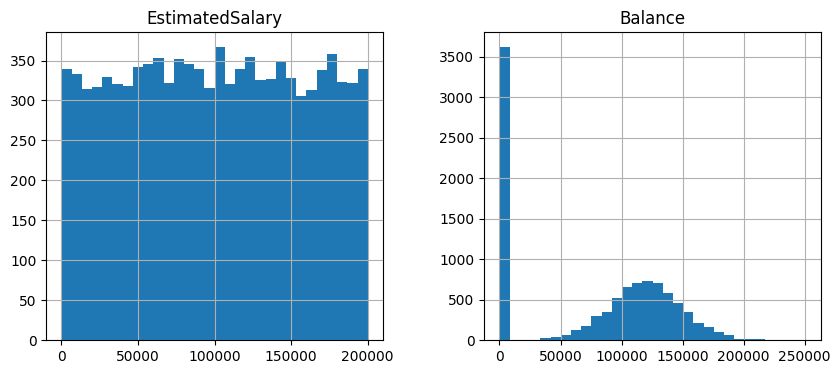

In [ ]:
#Balance and Estimated Salary
dt_final[['EstimatedSalary', 'Balance']].isnull().sum()
dt_final[['EstimatedSalary', 'Balance']].hist(bins=30, figsize=(10,4))

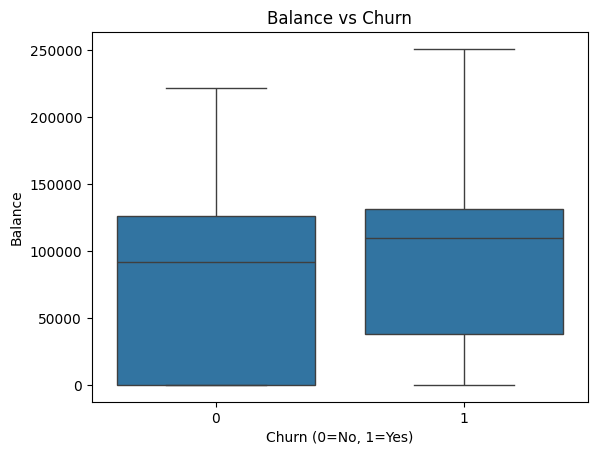

In [ ]:
sns.boxplot(data=dt_final, x='Exited', y='Balance')
plt.title('Balance vs Churn')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Balance')
plt.show()

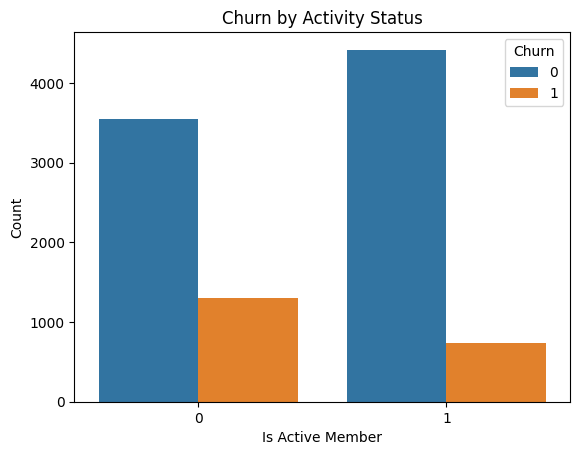

In [ ]:
sns.countplot(data=dt_final, x='IsActiveMember', hue='Exited')
plt.title('Churn by Activity Status')
plt.xlabel('Is Active Member')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show()

In [ ]:
#Dropping unnecessary columns
columns_to_drop = ['Age', 'CreditScore', 'Tenure', 'NumOfProducts','CustomerId','Surname','Geography','RowNumber']
dt_final.drop(columns=[col for col in columns_to_drop if col in dt_final.columns], inplace=True, errors='ignore')
dt_final

,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male,Age_18,Age_19,Age_20,...,Age_85,Age_88,Age_92,CreditGroup_Medium,CreditGroup_High,TenureGroup_Mid-term,TenureGroup_Loyal,Product_2,Product_3,Product_4
0,0.00,1,1,101348.88,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,83807.86,0,1,112542.58,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,159660.80,1,0,113931.57,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0.00,0,0,93826.63,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,125510.82,1,1,79084.10,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,1,0,96270.64,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0
9996,57369.61,1,1,101699.77,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9997,0.00,0,1,42085.58,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9998,75075.31,1,0,92888.52,1,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [ ]:
#Categorical
features_list = ['HasCrCard', 'IsActiveMember', 'Exited', 'Gender_Female', 'Gender_Male', 'Age_18', 'Age_19', 'Age_20', 'Age_21', 'Age_22', 'Age_23', 'Age_24', 'Age_25', 'Age_26', 'Age_27', 'Age_28', 'Age_29', 'Age_30', 'Age_31', 'Age_32', 'Age_33', 'Age_34', 'Age_35', 'Age_36', 'Age_37', 'Age_38', 'Age_39', 'Age_40', 'Age_41', 'Age_42', 'Age_43', 'Age_44', 'Age_45', 'Age_46', 'Age_47', 'Age_48', 'Age_49', 'Age_50', 'Age_51', 'Age_52', 'Age_53', 'Age_54', 'Age_55', 'Age_56', 'Age_57', 'Age_58', 'Age_59', 'Age_60', 'Age_61', 'Age_62', 'Age_63', 'Age_64', 'Age_65', 'Age_66', 'Age_67', 'Age_68', 'Age_69', 'Age_70', 'Age_71', 'Age_72', 'Age_73', 'Age_74', 'Age_75', 'Age_76', 'Age_77', 'Age_78', 'Age_79', 'Age_80', 'Age_81', 'Age_82', 'Age_83', 'Age_84', 'Age_85', 'Age_88', 'Age_92', 'CreditGroup_Medium', 'CreditGroup_High', 'TenureGroup_Mid-term', 'TenureGroup_Loyal', 'Product_2', 'Product_3', 'Product_4']
for col in df.columns:
  if col not in features_list:
    print(col,df[col].unique())
    print("."*50)

#numerical
numerical = ['EstimatedSalary', 'Balance']

RowNumber [    1     2     3 ...  9998  9999 10000]
..................................................
CustomerId [15634602 15647311 15619304 ... 15584532 15682355 15628319]
..................................................
Surname ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
..................................................
CreditScore [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 62

In [ ]:
#Training and Testing The Data
X = dt_final.drop('Exited', axis=1)
y = dt_final['Exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
print(y_train.value_counts())

Exited
0    6356
1    1644
Name: count, dtype: int64


In [31]:

X_train.columns = X_train.columns.str.replace('[<>[\] ]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[<>[\] ]', '_', regex=True)

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(y_train_smote.shape)
print(y_train_smote.value_counts())

(12712,)
Exited
0    6356
1    6356
Name: count, dtype: int64


In [26]:
models={
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoosting': xgb.XGBClassifier(random_state=42)}

In [27]:
cv_scores ={}
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("."*70)

Training Logistic Regression with default parameters


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression cross-validation accuracy: 0.86
......................................................................
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.87
......................................................................
Training XGBoosting with default parameters
XGBoosting cross-validation accuracy: 0.87
......................................................................


In [28]:
cv_scores

{'Logistic Regression': array([0.64058199, 0.87495085, 0.938631  , 0.91424076, 0.93233674]),
 'Random Forest': array([0.65159261, 0.86511994, 0.94177813, 0.93154996, 0.94020456]),
 'XGBoosting': array([0.64372788, 0.88360204, 0.94256491, 0.93823761, 0.9429583 ])}

In [29]:
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
y_test_pred = model.predict(X_test)
print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.8425
Confusion Matrix:
 [[1491  116]
 [ 199  194]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      1607
           1       0.63      0.49      0.55       393

    accuracy                           0.84      2000
   macro avg       0.75      0.71      0.73      2000
weighted avg       0.83      0.84      0.84      2000



XGBoosting crossvalidation gives the highest accuracy

Loading the Saved Model and Building a Predictive One